In [1]:
import cv2
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import imageio as io
import pandas as pd
import yaml
import sys
from matplotlib import patches
from pycocotools import mask as M

sys.path.append('../scripts')
import utils

min max temperature of each image

In [2]:
temp_annot_df = pd.read_csv(list(glob.glob('../../../dataset/*.csv'))[0]).drop('Unnamed: 0', axis=1)
temp_annot_df.image_name = temp_annot_df.image_name.apply(lambda x: x.rstrip('.jpg'))
temp_annot_df.set_index(keys='image_name', inplace=True, drop=True)

def create_temp_to_color_mapping(image_path):
    img = utils.rotate_to_vertical(image_path)
    spectrum, c_img = utils.extract_image_and_spectrum(img)
    idx = os.path.basename(image_path).rstrip('.jpg')
    min, max = temp_annot_df.loc[idx][['low_temperature', 'high_temperature']]
    print(idx, min, max)

read config and images

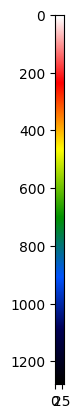

In [131]:
plt.imshow(spectrum)

In [3]:
with open('../config.yaml','r') as f:
    config = yaml.safe_load(f)
    
img_paths = sorted(glob.glob(config['dataset']['images']+'/img_thermal_*'))
    

In [4]:
img = utils.rotate_to_vertical(img_paths[0])
spectrum, cropped_image = utils.extract_image_and_spectrum(image=img)

normalize_image = lambda x: (x - x.mean(axis=(0, 1), keepdims=True)) / x.std(axis=(0, 1), keepdims=True)

plot channels and normalized image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


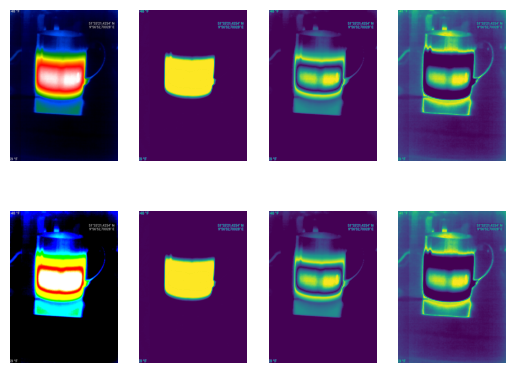

In [5]:
n_img = normalize_image(x=cropped_image)

fig, axs = plt.subplots(2,4)

axs[0][0].imshow(cropped_image)
axs[0][0].axis('off')

for i in range(1,4):
    axs[0][i].imshow(cropped_image[...,i-1])
    axs[0][i].axis('off')

axs[1][0].imshow(n_img)
axs[1][0].axis('off')
for i in range(1,4):
    axs[1][i].imshow(n_img[...,i-1])
    axs[1][i].axis('off')

# plt.imshow(cropped_image)
plt.show()

Thresholding

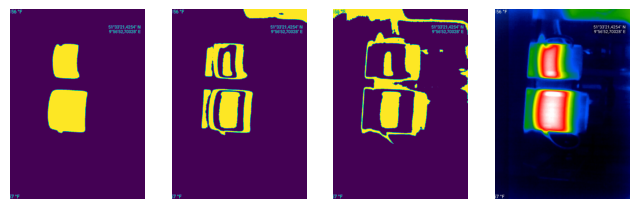

In [10]:
D = 2
ret, thresh1 = cv2.threshold(cropped_image[...,0], 255 // D, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(cropped_image[...,1], 255 // D, 255, cv2.THRESH_BINARY)
ret, thresh3 = cv2.threshold(cropped_image[...,2], 255 // D, 255, cv2.THRESH_BINARY)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(4*2,1*3))

for ax in (ax1, ax2, ax3, ax4):
    ax.axis('off')

ax1.imshow(thresh1)
ax2.imshow(thresh2)
ax3.imshow(thresh3)
ax4.imshow(cropped_image)
plt.show()
# plt.imshow(thresh)

### Different color maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


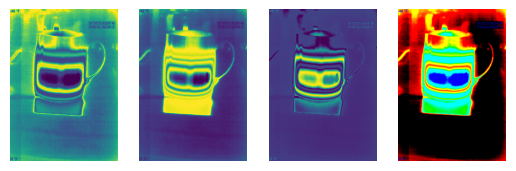

In [15]:
spectrum, c_img = utils.extract_image_and_spectrum(utils.rotate_to_vertical(img_paths[0]))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

for ax in (ax1, ax2, ax3, ax4):
    ax.axis('off')

cmap_img = cv2.applyColorMap(c_img, colormap=cv2.COLORMAP_TURBO)
n_img = normalize_image(cmap_img)
ax1.imshow(cmap_img[...,0])
ax2.imshow(cmap_img[...,1])
ax3.imshow(cmap_img[...,2])
ax4.imshow(n_img)
plt.show()

### Grabcut test

In [117]:

# max_idx = int(contour_areas.iloc[contour_areas.area.argmax()]['index'])

In [6]:
color_convs = {
    'HLS':cv2.COLOR_RGB2HLS, 
    'HSV': cv2.COLOR_RGB2HSV, 
    'LAB':cv2.COLOR_RGB2LAB, 
    'LUV': cv2.COLOR_RGB2LUV, 
    'YUV': cv2.COLOR_RGB2YUV
}

### Contours from image (histogram equalization, CLAHE)

In [7]:
def get_simple_contours(image_path, apply_ce=False, apply_blur=False, apply_clahe=False):
    _, c_img = utils.extract_image_and_spectrum(utils.rotate_to_vertical(image_path))
    og_img = c_img
    c_img = cv2.cvtColor(c_img, cv2.COLOR_RGB2GRAY)
    
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32))
        c_img = clahe.apply(c_img)
    
    if apply_ce:
        # Convert image to grayscale and apply histogram equalization
        c_img = cv2.equalizeHist(c_img)
        
    if apply_blur:
        c_img = cv2.GaussianBlur(c_img, (51, 51), 15)
    
    _, thresholded_image = cv2.threshold(c_img, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded_image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    new_contours = [np.squeeze(c, axis=1) for c in contours]

    contour_areas = pd.DataFrame([(int(i), cv2.contourArea(c)) for i, c in enumerate(contours)])
    contour_areas.columns = ['index','area']
    contour_areas.sort_values('area',ascending=False, inplace=True)
    contour_areas['index'] = contour_areas['index'].astype(int)
    
    return contour_areas, new_contours, c_img, og_img, thresholded_image

In [36]:
contour_areas, new_contours, c_img, og_img, thresholded_image = get_simple_contours(image_path=img_paths[5], apply_ce=False, apply_clahe=False)

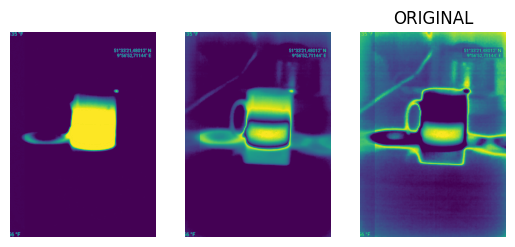

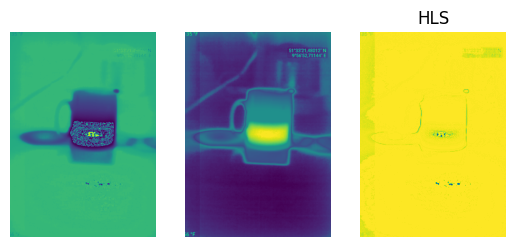

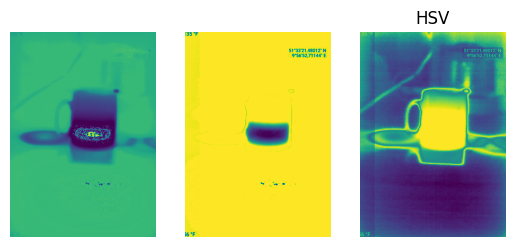

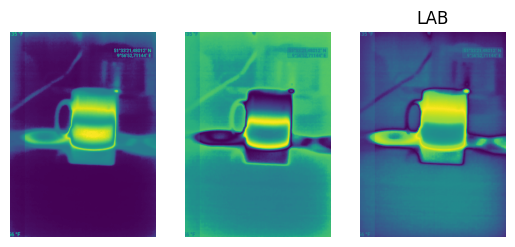

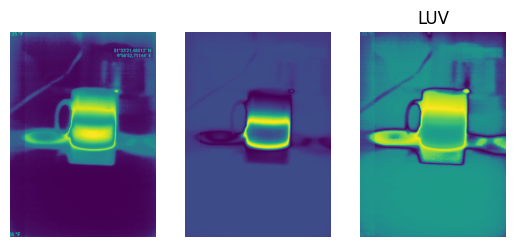

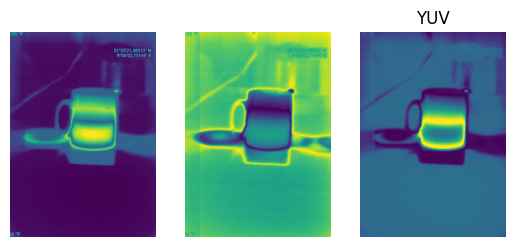

In [37]:
_, axs = plt.subplots(1,3)
for i in range(3):
    axs[i].imshow(og_img[...,i])
    axs[i].axis('off')
plt.title('ORIGINAL')
    
for color, color_conv in color_convs.items():
    cvt_img = cv2.cvtColor(og_img, color_conv)
    _, axs = plt.subplots(1,3)
    for i in range(3):
        axs[i].imshow(cvt_img[...,i])
        axs[i].axis('off')
    plt.title(color)

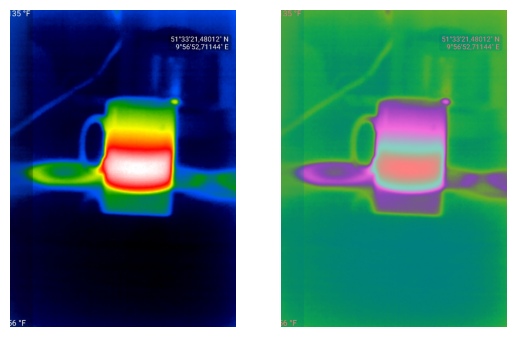

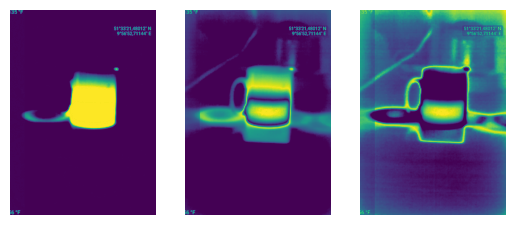

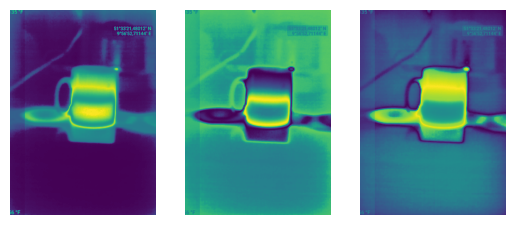

In [38]:
cvt_img = cv2.cvtColor(og_img, cv2.COLOR_RGB2LAB)
fig, (ax1, ax2) = plt.subplots(1,2)
for a in (ax1, ax2):
    a.axis('off')
    
ax1.imshow(og_img)
if cvt_img.shape[-1] in (1,3):
    ax2.imshow(cvt_img)

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
for a in (ax1, ax2, ax3):
    a.axis('off')
    
ax1.imshow(og_img[...,0])
ax2.imshow(og_img[...,1])
ax3.imshow(og_img[...,2])

fig, axs = plt.subplots(1,cvt_img.shape[-1])
for i in range(cvt_img.shape[-1]):
    axs[i].axis('off')
    axs[i].imshow(cvt_img[...,i])
    
plt.show()

In [151]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def np_norm(x):
    return (x - x.mean()) / x.std()

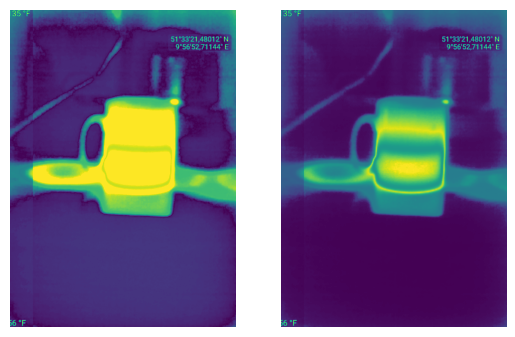

In [39]:
_, (ax1, ax2) = plt.subplots(1,2)
enhanced_img = cv2.convertScaleAbs(cvt_img[...,0], alpha=2,beta=-40)
ax1.imshow(enhanced_img)
ax1.axis('off')
ax2.imshow(cvt_img[...,0])
ax2.axis('off')
plt.show()

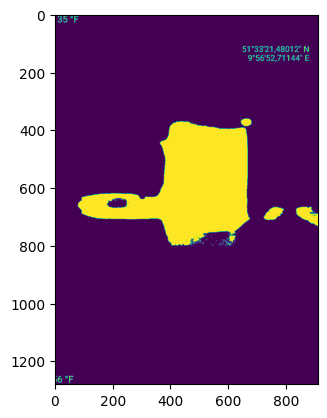

In [40]:
thresh, binary_image = cv2.threshold(enhanced_img, 200, 255, cv2.THRESH_BINARY)
plt.imshow(binary_image)

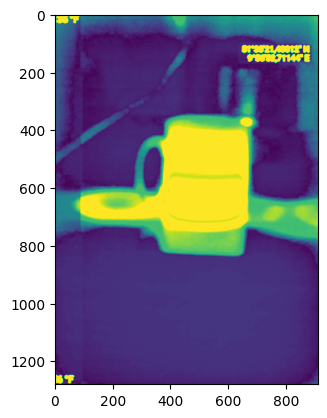

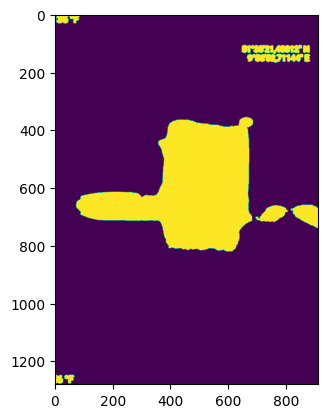

In [41]:
# EROSION/DILATION

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Adjust kernel size as needed
img_dilate = cv2.dilate(enhanced_img, kernel, iterations=2)
plt.imshow(img_dilate)
plt.show()
thresh, dilated_binary_image = cv2.threshold(img_dilate, 190, 255, cv2.THRESH_BINARY)
plt.imshow(dilated_binary_image)

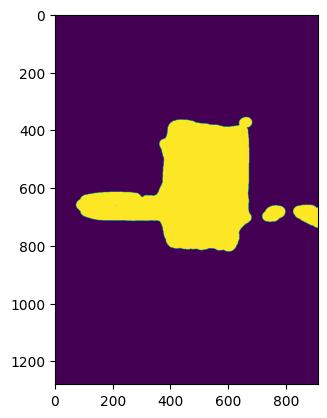

In [42]:
# OPENING OPENCV

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (37, 37))  # Adjust kernel size as needed
opened = cv2.morphologyEx(dilated_binary_image, cv2.MORPH_OPEN, kernel)

plt.imshow(opened)

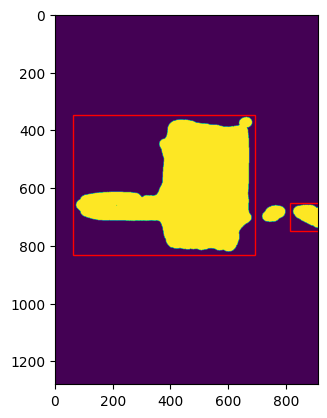

In [43]:
contours, _ = cv2.findContours(opened.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
new_contours = [np.squeeze(c, axis=1) for c in contours]

contour_areas = pd.DataFrame([(int(i), cv2.contourArea(c)) for i, c in enumerate(contours)])
contour_areas.columns = ['index', 'area']
contour_areas.sort_values('area', ascending=False, inplace=True)
contour_areas['index'] = contour_areas['index'].astype(int)
empty_img = np.zeros_like(opened)
plt.imshow(opened)

colors = ['green','blue','red','pink','yellow']

for idx, row in enumerate(contour_areas.iloc[:2].values):
    # rles = M.frPyObjects(new_contours[int(row[0])], h=opened.shape[0], w=opened.shape[1])
    # rle = M.merge(rles)
    # mask = M.decode(rle)
    bbox = cv2.boundingRect(new_contours[int(row[0])])
    plt.gca().add_patch(patches.Rectangle((bbox[0]-10, bbox[1]-10), bbox[2]+20, bbox[3]+20, facecolor='none', edgecolor='red'))
    # plt.gca().add_patch(patches.Polygon(new_contours[int(row[0])], closed=True, facecolor=colors[idx], edgecolor='white'))
plt.show()

### K-Means clustering

In [83]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2, random_state=0)
km.fit(enhanced_img.reshape(-1, 1))

KMeans(n_clusters=2, random_state=0)

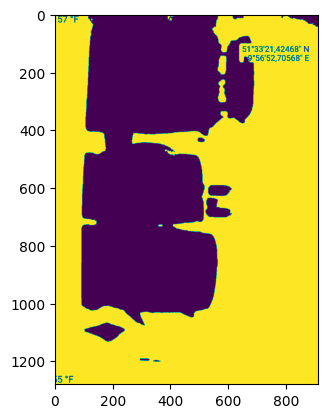

In [84]:
plt.imshow(km.labels_.reshape(*enhanced_img.shape))

### Contours from edges

In [191]:
def get_edge_contours(image_path, apply_ce=False, apply_blur=False, apply_clahe=False):
    _, c_img = utils.extract_image_and_spectrum(utils.rotate_to_vertical(image_path))
    og_img = c_img
    if apply_ce:
        # Convert image to grayscale and apply histogram equalization
        c_img = cv2.equalizeHist(cv2.cvtColor(c_img, cv2.COLOR_RGB2GRAY))
    else:
        # Ensure the image is in grayscale if CE isn't applied
        c_img = cv2.cvtColor(c_img, cv2.COLOR_RGB2GRAY)
    
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        c_img = clahe.apply(c_img)

    
    if apply_blur:
        c_img = cv2.GaussianBlur(c_img, (51, 51), 15)
    
    # Apply Canny edge detection
    edges = cv2.Canny(c_img, 50, 50)  # Adjust thresholds as needed

    # Find contours based on edges
    contours, _ = cv2.findContours(edges.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    new_contours = [np.squeeze(c, axis=1) for c in contours]

    contour_areas = pd.DataFrame([(int(i), cv2.contourArea(c)) for i, c in enumerate(contours)])
    contour_areas.columns = ['index', 'area']
    contour_areas.sort_values('area', ascending=False, inplace=True)
    contour_areas['index'] = contour_areas['index'].astype(int)
    
    return contour_areas, new_contours, c_img, edges


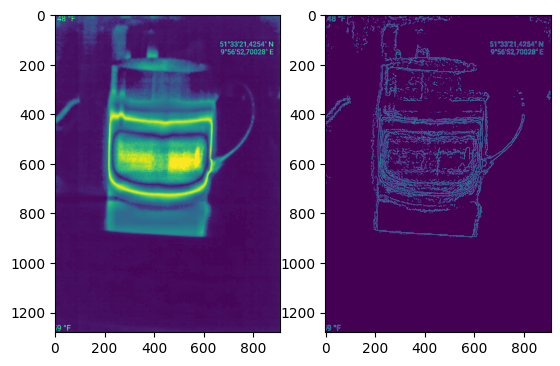

In [180]:
contour_areas, new_contours, c_img, edges = get_edge_contours(image_path=img_paths[0], apply_ce=False, apply_clahe=True)

_, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(c_img)
ax2.imshow(edges)
plt.show()

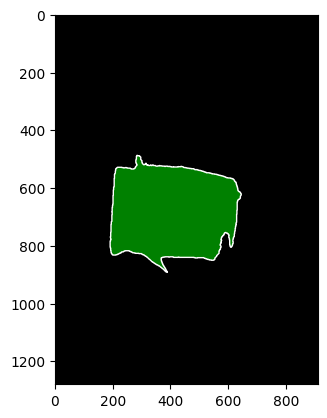

In [120]:
# max_idx = max(enumerate(contours), key=lambda x: cv2.contourArea(x[1]))[0]
empty_img = np.zeros_like(thresholded_image)
plt.imshow(empty_img)

colors = ['green','blue','red','pink','yellow']

for idx, row in enumerate(contour_areas.iloc[:1].values):
    plt.gca().add_patch(patches.Polygon(new_contours[int(row[0])], closed=True, facecolor=colors[idx], edgecolor='white'))
plt.show()

24